### Import modules and functions

In [104]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns

from pyspark import SparkContext, SparkConf
%matplotlib inline

%run '/Users/taldankovich/Documents/GitHub/Image_Processing/Functions/hist.py'

In [13]:
expdir='/Users/taldankovich/Documents/BicTurnover_180220/' #master folder

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
       
results = {"filename":[],
           "Early colour - spots mask":[],
           "Late colour - spots mask":[],
           "exp condition":[],
           "Early colour - Raw mean intensity":[],
           "Late colour - Raw mean intensity":[],
           "Mean correlation coefficient early/late":[],
           "Early colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Late colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Early colour - Total no. of spots in FOV":[],
           "Late colour - Total no. of spots in FOV":[],
           "Early colour - Mean spot area [nm]":[],
           "Late colour - Mean spot area [nm]":[],
           "Mean colour bias of a pixel (early=-1<x<1=late)":[]}        
for i in range(0,len(filelist)):
    if filelist[i].endswith(".nd2"):
        results["filename"].append(filelist[i])
        results["exp condition"].append(filelist[i].split('/')[-2])
        
early_channel_no=2
late_channel_no=1

/Users/taldankovich/Documents/BicTurnover_180220/1Day/06_60x_011.nd2


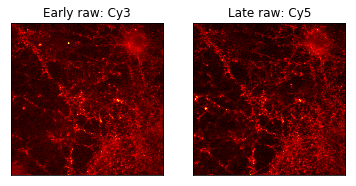

In [14]:
with ND2Reader(results["filename"][1]) as images:
        print(results["filename"][np.random.randint(1,len(results["filename"]))])
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        
        [channel1name, channel2name]=early_image.metadata['channels']
        if early_channel_no==2:
            early_channelname=channel2name
            late_channelname=channel1name
        else:
            early_channelname=channel1name
            late_channelname=channel2name

figno=1    
fig=plt.figure()
fig.add_subplot(1,2,figno)
plt.imshow(early_image,interpolation='none',cmap='hot')
plt.title('Early raw: '+early_channelname)
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
fig.add_subplot(1,2,figno+1)
plt.imshow(late_image,interpolation='none',cmap='hot')
plt.title('Late raw: '+late_channelname)
ax=plt.gca()
ax.grid(color='none')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
        

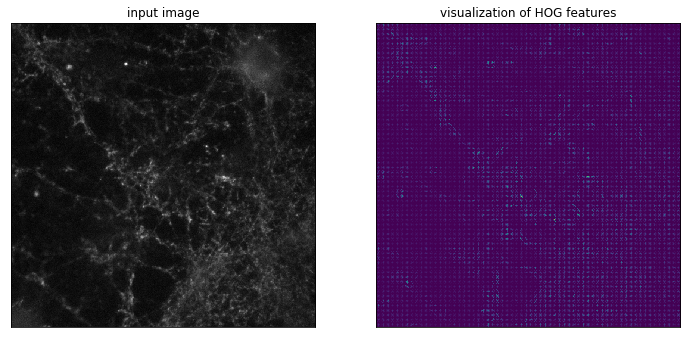

In [16]:
from skimage import data, color, feature
import skimage.data

image = early_image
hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [17]:
#attempt at gradient normalization
gradient=ndi.morphology.morphological_gradient(early_image,size=(3,3))


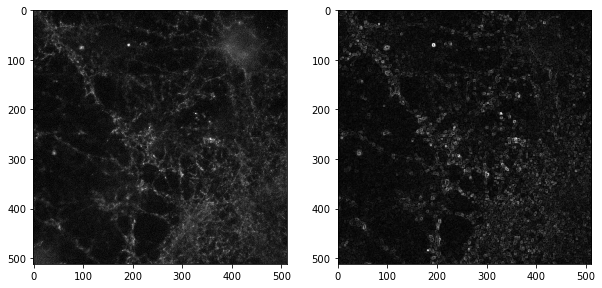

In [41]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(early_image,interpolation='none',cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(gradient,interpolation='none',cmap='gray')

(257,)
(1, 256)


/Users/taldankovich/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide


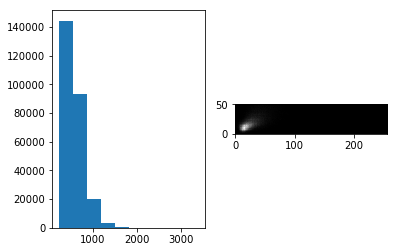

In [71]:
x=np.asarray(early_image)
y=np.asarray(gradient)
x=x.flatten()
y=y.flatten()

H, xedges, yedges = np.histogram2d(y,x,bins=(256,256))
#plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#plt.hist2d(x,y,bins=(256,256),cmap='gray')
#plt.show()
H.shape
fig=plt.figure()
fig.add_subplot(121)
plt.hist(x)
fig.add_subplot(122)
plt.imshow(H,cmap='gray',interpolation='none')
axes=plt.gca()
axes.set_ylim([0, 50])
print(yedges.shape)

ohm=np.sum(H,axis=0,keepdims=True)
gw=np.sum(np.multiply(H,yedges[0:-1]),axis=0,keepdims=True)
ag=np.divide(gw,ohm)
print(ag.shape)

In [83]:


newim=histogram_enhancement(early_image,etype='match', target=late_image, maxCount=16394)

3376
4074


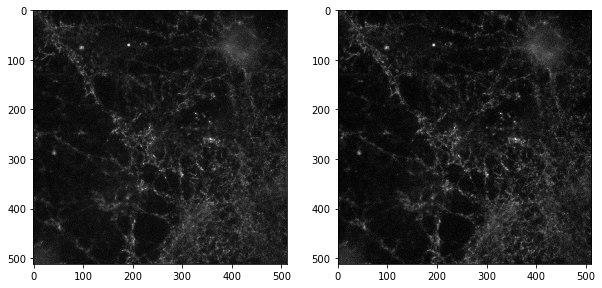

In [77]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(121)
plt.imshow(early_image,interpolation='none',cmap='gray')
fig.add_subplot(122)
plt.imshow(early_image,interpolation='none',cmap='gray')
plt.imshow(newim,interpolation='none',cmap='gray')

print(early_image.max())
print(newim.max())

